<a href="https://colab.research.google.com/github/DinethRubeh/GAN/blob/master/GAN_quickdraw_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Select Processing Devices

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import tensorflow as tf
print(tf.test.gpu_device_name())
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

/device:GPU:0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7314911872681693915, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5260649646810403548
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 18389885059250567917
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15695549568
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14036012002314845428
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#### Load Dependencies

In [4]:
# for data input and output
import numpy as np
import os

# for deep learning
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, BatchNormalization, Dropout, Flatten
from keras.layers import Activation, Reshape, Conv2DTranspose, UpSampling2D
from keras.optimizers import RMSprop

# for plotting
import pandas as pd
from matplotlib import pyplot as plt
# magic!!!
%matplotlib inline

#### Load Data

Numpy bitmap files from Google quickdraw_dataset,

https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap;tab=objects?prefix=

In [5]:
input_images = "/content/drive/My Drive/google colab/quickdraw_data/apple.npy"

In [6]:
data = np.load(input_images) # 28x28 grayscale bitmap in numpy .npy format; images are centered
print(data.shape)

(144722, 784)


In [7]:
print(data[1567])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0  93  33   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   3 231 243  59   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0  24 211 233  30   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  34 236 201
   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0  89 255  70   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   3 221 184   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   1  68 176 255 164 126  86   9   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  74 207 255 255 254 242 251 255 235  72   0   0   

In [8]:
data = data/255
data = np.reshape(data,(data.shape[0],28,28,1)) # fourth dimension is color
img_w, img_h = data.shape[1:3]
data.shape

(144722, 28, 28, 1)

In [9]:
# print(data[1567])

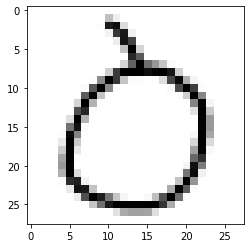

In [10]:
plt.imshow(data[1567,:,:,0], cmap='Greys')

#### Create Discriminator Network

In [11]:
def discriminator_builder(depth=64, p=0.4):
    
    # Define inputs
    inputs = Input((img_w,img_h,1))
    
    # Convolutional layers
    conv1 = Conv2D(depth*1, 5, strides=2, padding='same', activation='relu')(inputs)
    conv1 = Dropout(p)(conv1)
    
    conv2 = Conv2D(depth*2, 5, strides=2, padding='same', activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)
    
    conv3 = Conv2D(depth*4, 5, strides=2, padding='same', activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)
    
    conv4 = Conv2D(depth*8, 5, strides=1, padding='same', activation='relu')(conv3)
    conv4 = Flatten()(Dropout(p)(conv4))
    
    # Output layer
    output = Dense(1, activation='sigmoid')(conv4)
    
    # Model definition
    model = Model(inputs=inputs, outputs=output)
    model.summary()
    
    return model

In [12]:
discriminator = discriminator_builder()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 256)        

In [13]:
discriminator.compile(loss='binary_crossentropy',
                     optimizer=RMSprop(lr=0.0008, decay=6e-8, clipvalue=1.0),
                     metrics=['accuracy'])

#### Create Generator Network

Generator is a deconvolutional network in this case.
Takes features as input to create output image.

deconvolutional architecture:

Input features (noise/latent space cordinates) -> Dense layer -> Deconvolutional layers -> Output Image (Convolutional layer with 1 neuron)

Dense & deconvolutional layers are specifically designed,
BatchNormalization -> Activation

Upsampling layer is inverse of maxpooling layer

In [14]:
def generator_builder(z_dim=100, width=64, p=0.4):
    
    # define inputs
    inputs = Input((z_dim,))
    
    # first dense layer
    dense1 = Dense(7*7*64)(inputs)
    dense1 = BatchNormalization(momentum=0.9)(dense1)
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((7,7,64))(dense1)
    dense1 = Dropout(p)(dense1)
    
    # deconvolutional layers:
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(width/2), kernel_size=5, padding='same', activation=None)(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)
    
    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(width/4), kernel_size=5, padding='same', activation=None)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)
    
    conv3 = Conv2DTranspose(int(width/8), kernel_size=5, padding='same', activation=None)(conv2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)
    
    # output layer:
    output = Conv2D(1, kernel_size=5, padding='same', activation='sigmoid')(conv3)
    
    # model definition:
    model = Model(inputs=inputs, outputs=output)
    model.summary()
    
    return model

In [15]:
generator = generator_builder()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              316736    
_________________________________________________________________
batch_normalization (BatchNo (None, 3136)              12544     
_________________________________________________________________
activation (Activation)      (None, 3136)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 64)       

#### Create Adversarial network

half learning rate and decay crucial for performance

In [16]:
def adversarial_builder(z_dim=100):
    
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    
    model.compile(loss='binary_crossentropy',
                 optimizer=RMSprop(lr=0.0004, decay=3e-8, clipvalue=1.0),
                 metrics=['accuracy'])
    
    model.summary()
    
    return model

In [17]:
adversarial_model = adversarial_builder()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_3 (Functional)    (None, 28, 28, 1)         396961    
_________________________________________________________________
functional_1 (Functional)    (None, 1)                 4311553   
Total params: 4,708,514
Trainable params: 4,702,130
Non-trainable params: 6,384
_________________________________________________________________


#### GAN Theory

<!-- ![CV](imgs/gan_theory.png) -->
<table><tr><td><img src="imgs/gan_theory.png" width="600"></td></tr></table>

#### Train

In [18]:
def make_trainable(net, val):
    # Use this function to train model once and freeze weights
    # inputs: Neural net, boolean value
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [19]:
def train(epochs=2000, batch=120):
    
    d_metrics = []
    a_metrics = []
    
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    
    for i in range(epochs):
        # let's print perfomance every 100 epochs
        if i%100 == 0:
            print(i)
            
        real_imgs = np.reshape(data[np.random.choice(data.shape[0],batch,replace=False)],(batch,28,28,1)) # randomly select batch sizes from data np array
        fake_imgs = generator.predict(np.random.uniform(-1.0, 1.0, size=[batch, 100])) # uniform distribution from -1 to 1, size = return array size
        
        '''
        1. Train discriminator network on real/fake tagged images
        2. Freeze weights of discriminator network after 1 epoch
        3. Train adversarial network on fake images labelled as real
        '''
        # first job of discriminator network is to train on real/fake data set on 50:50 split
        x = np.concatenate((real_imgs, fake_imgs))
        # create label with 1 twice the batch size
        y = np.ones([2*batch,1])
        # turn half of labels to 0 (fake)
        y[batch:,:] = 0
        
        # set discriminator network to be trainable
        make_trainable(discriminator, True)
        
        # train discriminator and append to metrics list
        d_metrics.append(discriminator.train_on_batch(x,y))
        running_d_loss += d_metrics[-1][0] # discriminator.train_on_batch returns loss and accuracy respectively
        running_d_acc += d_metrics[-1][1]
        
        # Then train adversarial network
        # generate noise and label them as real
        noise = np.random.uniform(-1.0, 1.0, size=[batch, 100])
        y = np.ones([batch,1])
        
        # second job of discriminator network - train on generated images tagged as real
        a_metrics.append(adversarial_model.train_on_batch(noise,y))
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]
        
        # let's see adversarial performace each 500 epochs (less frequently)
        if (i+1)%500 == 0:
            
            print('Epoch #{}'.format(i+1))
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)
            
            # let's generate 16 images from genarator and plot them to see it's progression
            noise = np.random.uniform(-1.0, 1.0, size=[16, 100])
            gen_imgs = generator.predict(noise)
            
            plt.figure(figsize=(5,5))
            
            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], cmap='gray')
                plt.axis('off')
                
            plt.tight_layout()
            plt.show()
            
    return a_metrics, d_metrics

0
100
200
300
400
Epoch #500
499: [D loss: 0.494602, acc: 0.801528]  [A loss: 2.114038, acc: 0.112558]


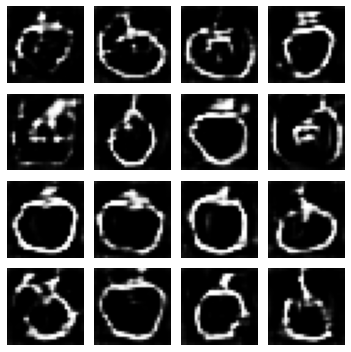

500
600
700
800
900
Epoch #1000
999: [D loss: 0.539475, acc: 0.747773]  [A loss: 1.694946, acc: 0.115407]


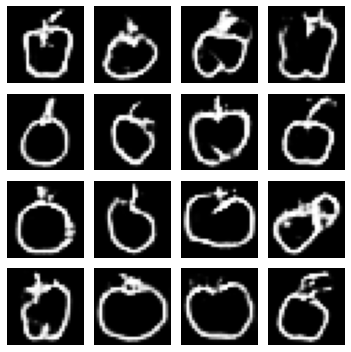

1000
1100
1200
1300
1400
Epoch #1500
1499: [D loss: 0.555434, acc: 0.730415]  [A loss: 1.571914, acc: 0.118790]


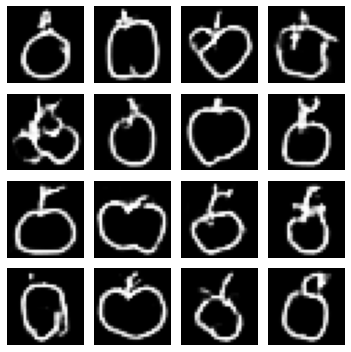

1500
1600
1700
1800
1900
Epoch #2000
1999: [D loss: 0.553588, acc: 0.730057]  [A loss: 1.554583, acc: 0.115524]


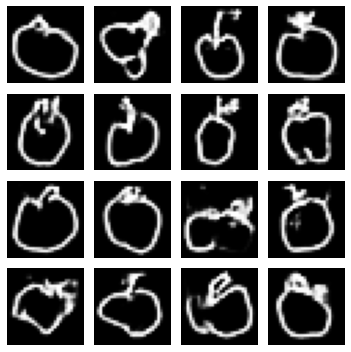

2000
2100
2200
2300
2400
Epoch #2500
2499: [D loss: 0.545086, acc: 0.736428]  [A loss: 1.625312, acc: 0.110251]


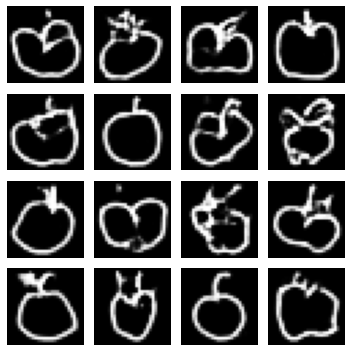

2500
2600
2700
2800
2900
Epoch #3000
2999: [D loss: 0.539573, acc: 0.740759]  [A loss: 1.722225, acc: 0.106566]


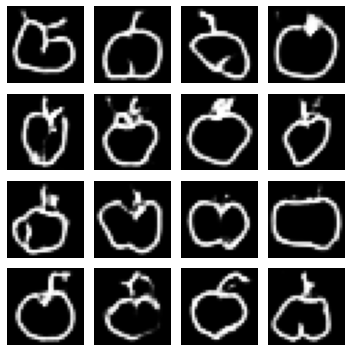

In [20]:
a_metrics_complete, d_metrics_complete = train(epochs=3000)

Text(0, 0.5, 'Loss')

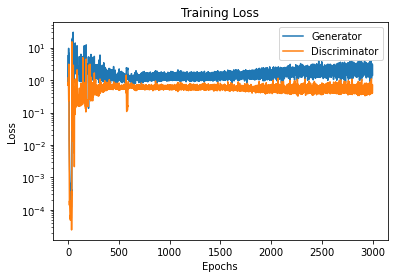

In [21]:
ax = pd.DataFrame(
    {
    'Generator': [metric[0] for metric in a_metrics_complete],
    'Discriminator': [metric[0] for metric in d_metrics_complete],
    }
).plot(title='Training Loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

Text(0, 0.5, 'Accuracy')

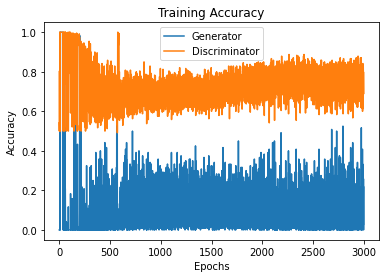

In [22]:
ax = pd.DataFrame(
    {
    'Generator': [metric[1] for metric in a_metrics_complete],
    'Discriminator': [metric[1] for metric in d_metrics_complete],
    }
).plot(title='Training Accuracy')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")